CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [6]:
!pip install captum

In [7]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [67]:
# TODO: Enter your code here
df = pd.read_csv('/content/drive/MyDrive/programming_assignment/hdb_price_prediction.csv')

cat_col_names=['month', 'town', 'flat_model_type', 'storey_range']
df.drop(columns=['full_address','nearest_stn']+cat_col_names,inplace=True)

# TODO: Enter your code here
df_train=df[df['year']<=2019].drop(columns=['year'])
df_val=df[df['year']==2020].drop(columns=['year'])
df_test=df[df['year']==2021].drop(columns=['year'])

> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [78]:
# TODO: Enter your code here
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

def process_data(data,scaler=None,scaler_train=False):
  X=np.array(data.drop(columns=['resale_price']))
  y=np.array(data['resale_price'])

  if scaler:
    if scaler_train: X=scaler.fit_transform(X)
    else: X=scaler.transform(X)

  X=torch.tensor(X).float()
  y=torch.tensor(y).view(-1,1).float()
  return X,y

X_train,y_train=process_data(df_train)
X_val,y_val=process_data(df_val)
X_test,y_test=process_data(df_test)

batch_size=32
datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=True)

In [69]:
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_output):
        super().__init__()
        self.lin1=nn.Linear(no_features,no_hidden[0])
        self.relu1=nn.ReLU() #relu activation fn
        self.lin2=nn.Linear(no_hidden[0],no_hidden[1])
        self.relu2=nn.ReLU()
        self.lin3=nn.Linear(no_hidden[1],no_hidden[2])
        self.relu3=nn.ReLU()
        self.lin4=nn.Linear(no_hidden[2],no_output)

    def forward(self,x):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(x)))))))

def train(model_inp, num_epochs=50, learning_rate=0.01, criterion=nn.MSELoss(reduction='sum')):
    optimizer=torch.optim.Adam(model_inp.parameters(),lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

In [70]:
model=MLP(X_train.shape[1],[5,5,5],1)
model.train()
train(model)
model.eval()
outputs=model(X_test)

err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))
print('model err: ', err)

Epoch [1]/[50] running accumulative loss across all batches: 1607919794450432.000
Epoch [21]/[50] running accumulative loss across all batches: 264813444247552.000
Epoch [41]/[50] running accumulative loss across all batches: 256644124131328.000
model err:  89417.1


In [71]:
import matplotlib.pyplot as plt

def model_explainability(model,feature_names,test_sample):
  methods={'sa':Saliency(model),'ixg':InputXGradient(model),'ig':IntegratedGradients(model),'gs':GradientShap(model),'fa':FeatureAblation(model)}
  attr_test_norm_sum_dict={}

  for key,value in methods.items():
    if key=='ig':
      attr_test=value.attribute(test_sample,n_steps=50)
    elif key=='gs':
      attr_test=value.attribute(test_sample,X_train)
    else:
      attr_test=value.attribute(test_sample)
    attr_test_sum=attr_test.detach().numpy().sum(0)
    attr_test_norm_sum=attr_test_sum/np.linalg.norm(attr_test_sum, ord=1)
    attr_test_norm_sum_dict[key]=attr_test_norm_sum

  x_axis_data = np.arange(X_test.shape[1])
  x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

  lin_weight = model.lin1.weight[0].detach().numpy()
  y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

  width = 0.14
  legends = ['Saliency', 'Input x Gradients','Integrated Gradients', 'GradientSHAP', 'Feature Ablation', 'Weights']

  plt.figure(figsize=(20, 10))

  ax = plt.subplot()
  ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
  ax.set_ylabel('Attributions')

  FONT_SIZE = 16
  plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
  plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
  plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
  plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend
  colours=['#34b8e0','#A90000','#eb5e7c','#4260f5','#49ba81']

  for i in range(len(attr_test_norm_sum_dict)):
    ax.bar(x_axis_data + i*width, list(attr_test_norm_sum_dict.values())[i], width, align='center', alpha=0.5+(0.1*i), color=colours[i])

  ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
  ax.autoscale_view()
  plt.tight_layout()

  ax.set_xticks(x_axis_data + 0.5)
  ax.set_xticklabels(x_axis_data_labels)

  plt.legend(legends, loc=3)
  plt.show()

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


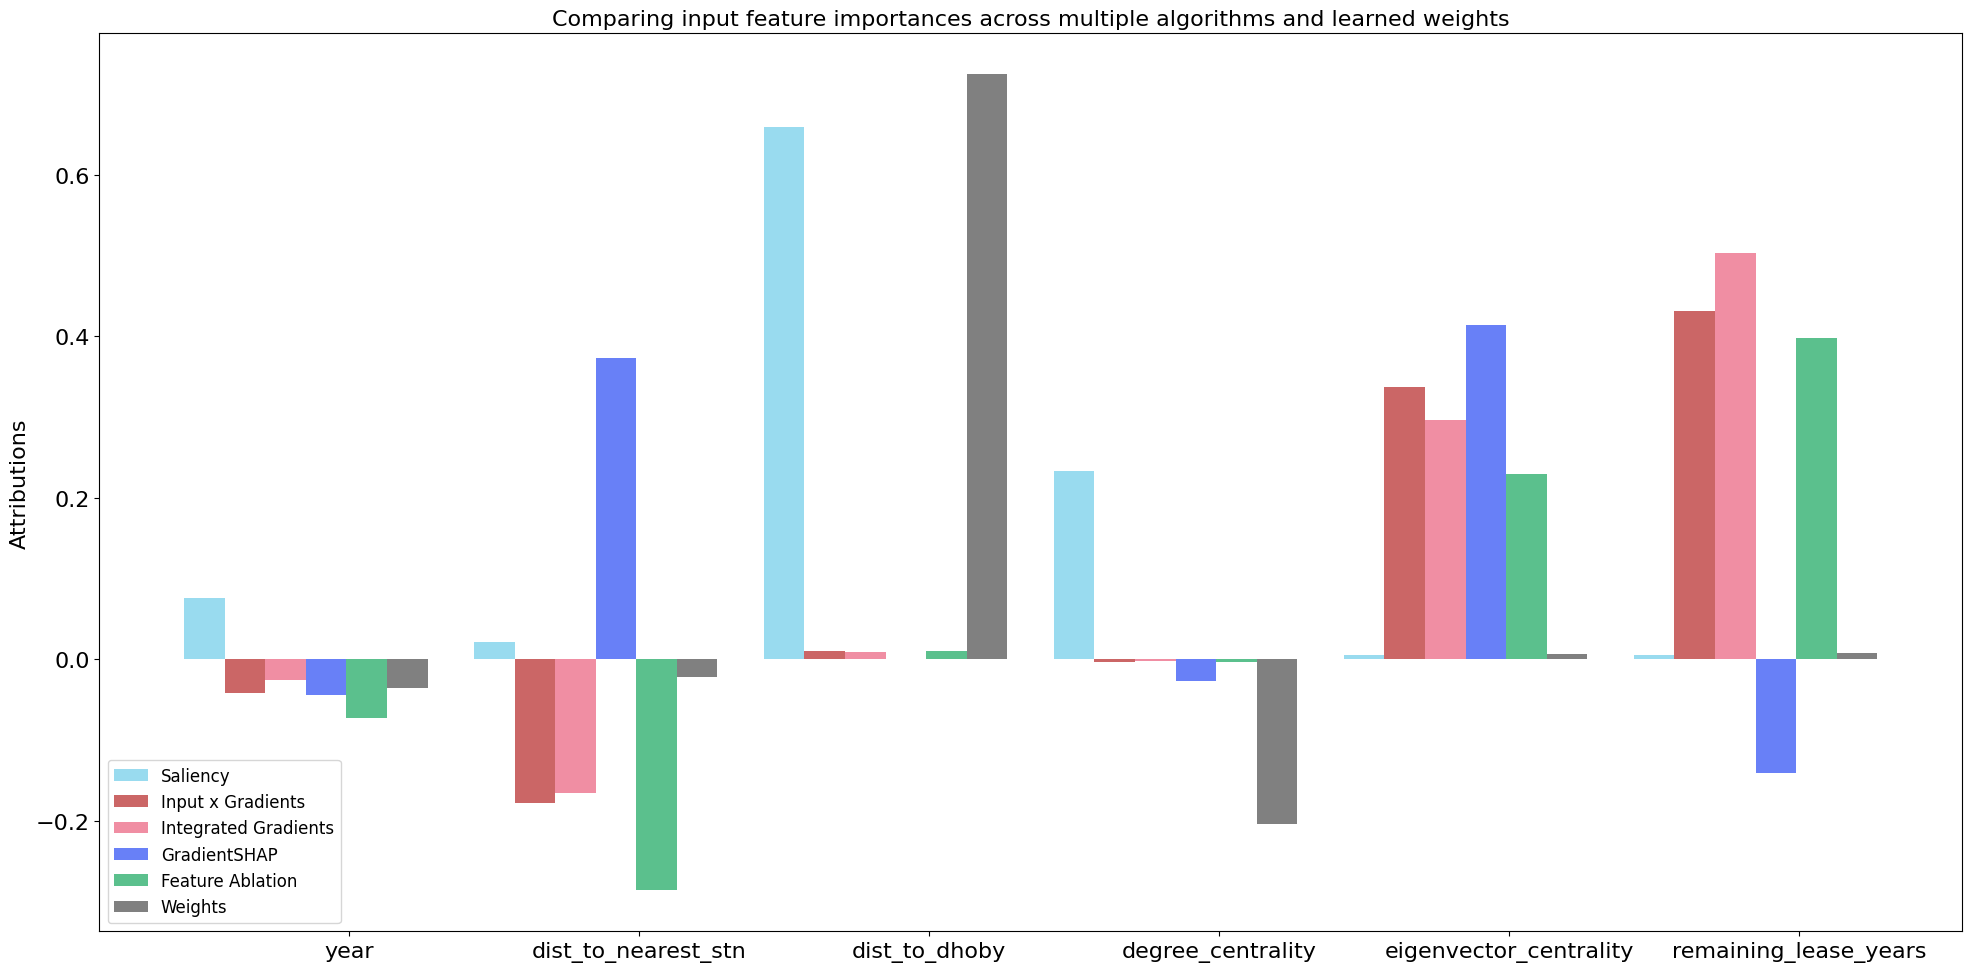

In [72]:
feature_names=df.drop(columns=['resale_price']).columns
test_sample=X_test[np.random.choice(len(X_test),size=500,replace=False)]

model_explainability(model,feature_names,test_sample)

> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


Epoch [1]/[50] running accumulative loss across all batches: 2289819738996736.000
Epoch [21]/[50] running accumulative loss across all batches: 208252114774016.000
Epoch [41]/[50] running accumulative loss across all batches: 207574731767808.000
model err:  91842.586


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


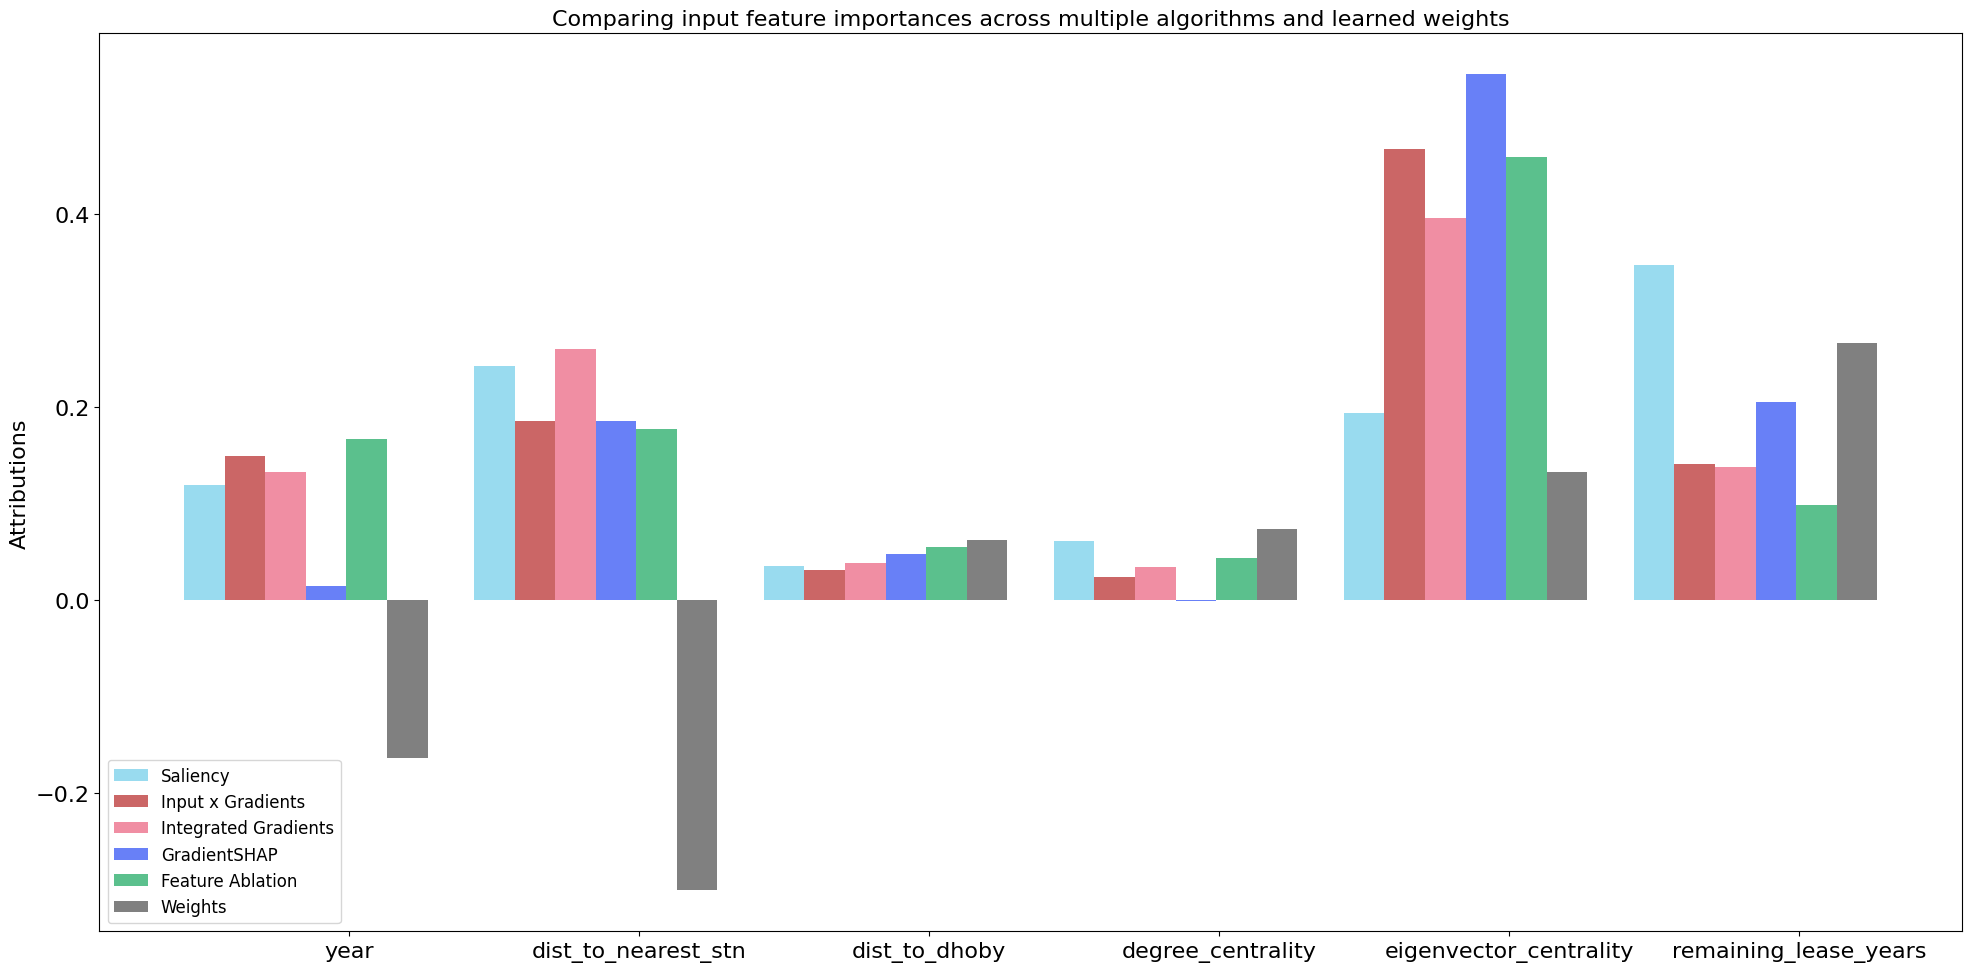

In [79]:
# TODO: Enter your code here
scaler=StandardScaler()
X_train,y_train=process_data(df_train,scaler,scaler_train=True)
X_val,y_val=process_data(df_val,scaler)
X_test,y_test=process_data(df_test,scaler)

batch_size=32
datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=True)

model=MLP(X_train.shape[1],[5,5,5],1)
model.train()
train(model)
model.eval()
outputs=model(X_test)

err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))
print('model err: ', err)

test_sample=X_test[np.random.choice(len(X_test),size=500,replace=False)]
model_explainability(model,feature_names,test_sample)

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores similar to IG?


Saliency helps to understand which features are most influential for a particular data point when making the resale price prediction while IG calculates the overall importance of features across the entire input distribution. Saliency and IG produced similar scores due to the features being relatively independent of each other and data normalization, causing gradient measure to be relatively the same.|

\# TODO: \<Enter your answer here\>

> Why did Input x Gradients give the same attribution scores as IG?


Input x Gradients offer a local view of feature influence, calculating gradients for a specific input to identify influential features. Integrated Gradients provides a global perspective by integrating gradients along a path from a baseline to understand feature importance across the entire input space. Input x Gradients and IG give the same attribution scores due to homogenous data and data normalization.

\# TODO: \<Enter your answer here\>